<a href="https://colab.research.google.com/github/MeghaPujamath/ReinforcementLearning-DQN-and-PPO-Implementation-for-Cartpole-Environment-/blob/main/DQN_and_PPO_Implementation_for_Cartpole_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DQN Implementation**

In [80]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

**Hyper-parameters Initialization**

In [81]:
batch_size = 32 #No of transitions that we sample from replay buffer while calculating gradients
n_episodes = 1001
discountFactor = 0.99
epsilon = 1.0
epsilonFactor = 10000
minEpsilon = 0.02
learning_rate = 0.001
buffer_size = 50000 #Max No of trqnsitions that we store before clearing out
min_replay_size = 1000 #No of transitions stored in replay buffer before we start computing gradients and training
target_update_fre = 1000 #no of steps that we update target paramters equal to online parameters
episode_length = 100

**Environment Settings**

In [82]:
env = gym.make('CartPole-v0')
memory = deque(maxlen=buffer_size)
reward_buffer = deque()

state_size = env.observation_space.shape
action_size = env.action_space.n

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

**Neural Network Class Implementation**

In [83]:
class ModelNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    input_features = int(np.prod(state_size))
    self.net = nn.Sequential(nn.Linear(input_features, 64), nn.Tanh(), nn.Linear(64, action_size))

  def forward(self, x):
    return self.net(x)

  def act(self, state):
    state_t = torch.as_tensor(state, dtype=torch.float32) #converting state to torch tensor
    q_values = main_net(state_t.unsqueeze(0)) #Creating fake batch dimensions of 1

    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() # converting torch tensor to integer
    return action

**Initializing Networks**

In [84]:
main_net = ModelNetwork(env) #Main network is actually trained
target_net = ModelNetwork(env) #target network is used to generate target values or ground truth

target_net.load_state_dict(main_net.state_dict())
optimizer = torch.optim.Adam(main_net.parameters(), learning_rate)

**Defining Replay Buffer Class**

In [85]:
class ReplayBuffer:
  def __init__(self, buffer_size=buffer_size):
    self.buffer_size = buffer_size
    self.buffer = deque(maxlen=self.buffer_size)
  
  def insert_replayBuffer(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))
  
  def sample_replayBuffer(self, batch_size):
    return random.sample(self.buffer, batch_size)
  
  def buffer_initialization(self, env, min_replay_size):
    state = env.reset()
    for _ in range(min_replay_size):
      action = env.action_space.sample()
      next_state, reward, done, _ = env.step(action)
      self.insert_replayBuffer(state, action, reward, next_state, done)

      state = next_state
      if done:
        state = env.reset()

**Replay Buffer Training Function**

In [86]:
def ReplayBufferLearn(batch_size, minibatch):
    states = np.asarray([m[0] for m in minibatch])
    actions = np.asarray([m[1] for m in minibatch])
    rewards = np.asarray([m[2] for m in minibatch])
    next_states = np.asarray([m[3] for m in minibatch])
    dones = np.asarray([m[4] for m in minibatch])

    states_t = torch.as_tensor(states, dtype=torch.float32)
    actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
    done_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
    next_states_t = torch.as_tensor(next_states, dtype=torch.float32)

    #Actual q values or ground truth from target network using next state
    target_q_values = target_net(next_states_t) 
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    targets = rewards_t + discountFactor*(1-done_t)*max_target_q_values
    # test = torch.tensor(targets, requires_grad=True)

    #Predicted q values from main network using current state
    q_values = main_net(states_t)
    # action_q_values, _ = torch.max(q_values, axis=1)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)
    # test2 = torch.tensor(action_q_values, requires_grad=True)

    #Compute Losses
    # loss = nn.functional.smooth_l1_loss(action_q_values, targets)
    loss = torch.nn.MSELoss()(action_q_values, targets)

    #Gradient Descent Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

**Training Loop**

In [87]:
rb = ReplayBuffer()
rb.buffer_initialization(env, min_replay_size)
episode_reward = 0.0
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
loss_test = []
loss_test2 = []
losses = 0
state = env.reset()
steps = 0
epis_len = 0
for e in itertools.count():
  epis_len += 1
  epsi = np.interp(e, [0, epsilonFactor], [epsilon, minEpsilon])
  if random.random() <= epsi:
    action = env.action_space.sample() #random action selection i.e exploring
  else:
    action = main_net.act(state)

  next_state, reward, done, _ = env.step(action)
  memory.append((state, action, reward, next_state, done))

  state = next_state
  episode_reward += reward
  if done:
    steps += 1
    state = env.reset()
    reward_buffer.append(episode_reward)
    
    losses_list.append(losses/epis_len)

    print(f'At Episode {steps} with Reward {episode_reward} and Average Reward {np.mean(reward_buffer)}')
    episode_reward = 0.0
    epis_len = 0

  miniBatch = rb.sample_replayBuffer(batch_size)
  loss = ReplayBufferLearn(batch_size, miniBatch)
  losses += loss

  #Update the Target Network
  if e % target_update_fre== 0:
    target_net.load_state_dict(main_net.state_dict())
  
  epsilon_list.append(epsi)
  
  if(len(reward_buffer) > 700):
    break

At Episode 1 with Reward 54.0 and Average Reward 54.0
At Episode 2 with Reward 11.0 and Average Reward 32.5
At Episode 3 with Reward 10.0 and Average Reward 25.0
At Episode 4 with Reward 41.0 and Average Reward 29.0
At Episode 5 with Reward 26.0 and Average Reward 28.4
At Episode 6 with Reward 21.0 and Average Reward 27.166666666666668
At Episode 7 with Reward 14.0 and Average Reward 25.285714285714285
At Episode 8 with Reward 24.0 and Average Reward 25.125
At Episode 9 with Reward 15.0 and Average Reward 24.0
At Episode 10 with Reward 34.0 and Average Reward 25.0
At Episode 11 with Reward 10.0 and Average Reward 23.636363636363637
At Episode 12 with Reward 18.0 and Average Reward 23.166666666666668
At Episode 13 with Reward 19.0 and Average Reward 22.846153846153847
At Episode 14 with Reward 31.0 and Average Reward 23.428571428571427
At Episode 15 with Reward 19.0 and Average Reward 23.133333333333333
At Episode 16 with Reward 15.0 and Average Reward 22.625
At Episode 17 with Reward 2

**PPO Implementation**

In [88]:
import torch
from torch import nn
import random
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from torch.distributions.categorical import Categorical

In [89]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [90]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir=''):
        super(ActorNetwork, self).__init__()
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

In [91]:
class CriticNetwork(nn.Module):
  def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256):
        super(CriticNetwork, self).__init__()
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
  def forward(self, state):
      value = self.critic(state)
      return value

In [92]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)
    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()
        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()
        return action, probs, value
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)
            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
        self.memory.clear_memory() 

In [93]:
env = gym.make('CartPole-v0')
N = 20
batch_size = 32
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,alpha=alpha, n_epochs=n_epochs, 
                  input_dims=env.observation_space.shape)
n_games = 600
best_score = env.reward_range[0]
rewards2 = []
learn_iters = 0
avg_score = 0
n_steps = 0

In [94]:
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    rewards2.append(score)
    avg_score = np.mean(rewards2[-100:])

    if avg_score > best_score:
        best_score = avg_score

    print("steps = ", n_steps,  ' episode = ', i, ' reward %.1f' % score, 'average reward %.1f' % avg_score)

steps =  22  episode =  0  reward 22.0 average reward 22.0
steps =  36  episode =  1  reward 14.0 average reward 18.0
steps =  67  episode =  2  reward 31.0 average reward 22.3
steps =  102  episode =  3  reward 35.0 average reward 25.5
steps =  128  episode =  4  reward 26.0 average reward 25.6
steps =  161  episode =  5  reward 33.0 average reward 26.8
steps =  173  episode =  6  reward 12.0 average reward 24.7
steps =  200  episode =  7  reward 27.0 average reward 25.0
steps =  227  episode =  8  reward 27.0 average reward 25.2
steps =  246  episode =  9  reward 19.0 average reward 24.6
steps =  273  episode =  10  reward 27.0 average reward 24.8
steps =  295  episode =  11  reward 22.0 average reward 24.6
steps =  339  episode =  12  reward 44.0 average reward 26.1
steps =  359  episode =  13  reward 20.0 average reward 25.6
steps =  384  episode =  14  reward 25.0 average reward 25.6
steps =  397  episode =  15  reward 13.0 average reward 24.8
steps =  417  episode =  16  reward 2

**Results of Both DQN and PPO algorithm**

**DQN Results:**

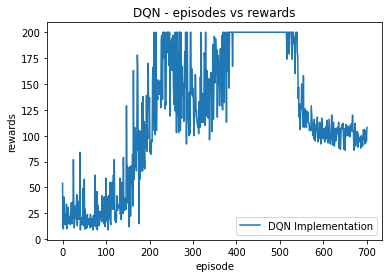

In [95]:
x = [i+1 for i in range(len(rewards2))]
fig, ax = plt.subplots()
plt.title('DQN - episodes vs rewards')
plt.plot(reward_buffer, label='DQN Implementation')
plt.xlabel("episode")
plt.ylabel("rewards")
plt.legend()
plt.show()

**PPO Results:**

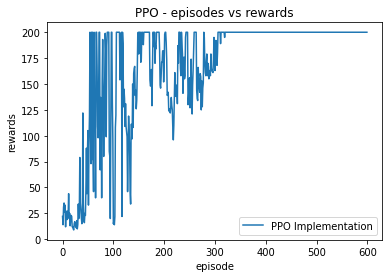

In [96]:
fig, ax = plt.subplots()
plt.title('PPO - episodes vs rewards')
plt.plot(rewards2, label='PPO Implementation')
plt.xlabel("episode")
plt.ylabel("rewards")
plt.legend()
plt.show()

In [97]:
v_list = list(reward_buffer)
v_list = v_list[:600]
running_avg1 = np.zeros(len(v_list))
running_avg2 = np.zeros(len(rewards2))
for i in range(len(running_avg1)):
  running_avg1[i] = np.mean(v_list[max(0, i-100):(i+1)])
  running_avg2[i] = np.mean(rewards2[max(0, i-100):(i+1)])

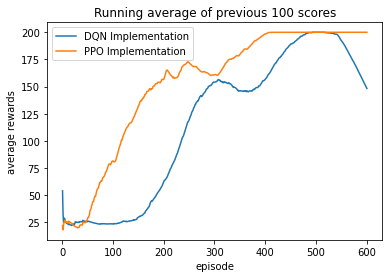

In [98]:
fig, ax = plt.subplots()
plt.title('Running average of previous 100 scores')
plt.plot(x[:999], running_avg1[:999], label='DQN Implementation')
plt.plot(x[:999], running_avg2[:999], label='PPO Implementation')
plt.xlabel("episode")
plt.ylabel("average rewards")
plt.legend()
plt.show()

1. From the above plot it is clear that, PPO implementation performance is more reliable and it reaches the expected reward (200) much earlier than DFQ.
2. The DFQ implementation is much noiser when compared to PPO